# DilemmaAgent: LLM Behavior in Game Theoretical Scenarios Analysis

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from app.utils.experiment_storage import ExperimentStorage
from app.utils.experiment_analyzer import ExperimentAnalyzer

## 1. Load Data

In [2]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /Users/jonahdykhuizen/Dev/DilemmaAgent/backend


In [3]:
storage = ExperimentStorage()
experiments_df = storage.get_experiments_summary()

## 2. Cooperation Rate Analysis

In [ ]:
def plot_cooperation_rates(experiment_id):
    results = storage.get_experiment_results(experiment_id)
    games_df = pd.DataFrame([
        {
            'game_number': i,
            'cooperation_rate': game.cooperation_rate,
            'strategy': results.player2_strategy
        }
        for i, game in enumerate(results.games)
    ])
    
    plt.figure(figsize=(12,6))
    sns.boxplot(data=games_df, x='strategy', y='cooperation_rate')
    plt.title(f'Cooperation Rates by Strategy\nMatrix: {results.matrix_type}')
    plt.show()


## 3. Score Distribution Analysis

In [ ]:
def plot_score_distributions(experiment_id):
    results = storage.get_experiment_results(experiment_id)
    scores_df = pd.DataFrame([
        {
            'game_number': i,
            'ai_score': game.final_scores[0],
            'opponent_score': game.final_scores[1],
            'strategy': results.player2_strategy,
        }
        for i, game in enumerate(results.games)
    ])
    
    plt.figure(figsize=(12,6))
    sns.violinplot(data=scores_df.melt(id_vars=['strategy'], 
                                     value_vars=['ai_score', 'opponent_score']),
                  x='strategy', y='value', hue='variable')
    plt.title(f'Score Distributions\nMatrix: {results.matrix_type}')
    plt.show()

## 4. Token Usage Analysis

In [ ]:
def plot_token_usage(experiment_id):
    results = storage.get_experiment_results(experiment_id)
    token_df = pd.DataFrame([
        {
            'round': r.round_number,
            'game': i,
            'tokens': r.token_usage.total_tokens if r.token_usage else 0,
            'strategy': results.player2_strategy
        }
        for i, game in enumerate(results.games)
        for r in game.rounds
    ])
    
    plt.figure(figsize=(12,6))
    sns.lineplot(data=token_df, x='round', y='tokens', hue='strategy')
    plt.title(f'Token Usage Over Time\nMatrix: {results.matrix_type}')
    plt.show()

## 5. Reasoning Analysis

In [ ]:
def analyze_reasoning(experiment_id):
    results = storage.get_experiment_results(experiment_id)
    reasoning_df = pd.DataFrame([
        {
            'round': r.round_number,
            'game': i,
            'reasoning': r.player1_reasoning,
            'move': r.player1_move.value,
            'strategy': results.player2_strategy
        }
        for i, game in enumerate(results.games)
        for r in game.rounds
    ])
    
    # Basic text analysis of reasoning
    from collections import Counter
    import nltk
    nltk.download('punkt')
    nltk.download('stopwords')
    
    words = ' '.join(reasoning_df['reasoning']).lower().split()
    word_freq = Counter(words).most_common(20)
    
    plt.figure(figsize=(12,6))
    sns.barplot(x=[w[0] for w in word_freq], y=[w[1] for w in word_freq])
    plt.xticks(rotation=45)
    plt.title('Most Common Words in AI Reasoning')
    plt.show()

# Experimentation

In [ ]:
experiment_id = '9874f0f2-739c-4134-9093-c7a13d482890'

In [ ]:
plot_cooperation_rates(experiment_id)
plot_score_distributions(experiment_id)
plot_token_usage(experiment_id)
analyze_reasoning(experiment_id)

In [ ]:
results = storage.get_experiment_results(experiment_id)

# Experiment

## Functions

In [4]:
def display_experiment_overview():
    """Show basic information about all experiments"""
    storage = ExperimentStorage()
    experiments_df = storage.get_experiments_summary()
    
    overview = experiments_df[['experiment_id', 'matrix_type', 'player1_strategy', 
                             'player2_strategy', 'total_games', 'cooperation_rate']]
    
    # Add duration column
    overview['duration'] = pd.to_datetime(experiments_df['end_time']) - pd.to_datetime(experiments_df['start_time'])
    
    print("Available Experiments:")
    display(overview)
    return overview

In [49]:
def analyze_experiments(experiment_id: str):
    """Display game statistics for a specific experiment"""
    storage = ExperimentStorage()
    
    # Get experiment metadata
    experiments_df = storage.get_experiments_summary()
    exp = experiments_df[experiments_df['experiment_id'] == experiment_id].iloc[0]
    
    # Read game data
    games_df = pd.read_csv(storage.csv_dir / f"{experiment_id}_games.csv")
    
    # Group by game_id to get game-level stats
    game_stats = games_df.groupby('game_id').agg({
        'matrix_type': 'first',
        'player1_move': lambda x: (x == 'cooperate').mean(),  # cooperation rate
        'player2_move': lambda x: (x == 'cooperate').mean(),
        'cumulative_player1_score': 'last',  # final scores
        'cumulative_player2_score': 'last',
        'player2_reasoning': 'first'  # strategy name
    }).reset_index()
    
    game_stats['winner'] = np.where(
        game_stats['cumulative_player1_score'] > game_stats['cumulative_player2_score'],
        'AI', 'Opponent')
        
    game_stats.columns = ['game_id', 'matrix_type', 'p1_coop_rate', 'p2_coop_rate', 
                         'p1_final_score', 'p2_final_score', 'opponent_strategy', 'winner']
    
    print(f"\nAnalysis for experiment {experiment_id}")
    print(f"Matrix Type: {exp.matrix_type}")
    print(f"Player 1: {exp.player1_strategy}")
    print(f"Player 2: {exp.player2_strategy}")
    print("\nGame Statistics:")
    display(game_stats)
    
    return game_stats

In [27]:
def view_game_details(game_id: str):
    """View detailed round-by-round information for a specific game"""
    # Set pandas display options for better readability
    pd.set_option('display.max_colwidth', None)  # Show full reasoning
    pd.set_option('display.max_rows', None)      # Show all rounds
    pd.set_option('display.width', None)         # Auto-adjust width
    
    storage = ExperimentStorage()
    
    # Find which experiment contains this game
    for exp_id in storage.get_experiments_summary()['experiment_id']:
        games_df = pd.read_csv(storage.csv_dir / f"{exp_id}_games.csv")
        game_rounds = games_df[games_df['game_id'] == game_id]
        
        if len(game_rounds) > 0:
            print(f"Game ID: {game_id}")
            print(f"Matrix Type: {game_rounds['matrix_type'].iloc[0]}")
            print(f"Opponent Strategy: {game_rounds['player2_reasoning'].iloc[0]}")
            print(f"Final Score - AI: {game_rounds['cumulative_player1_score'].iloc[-1]}, " 
                  f"Opponent: {game_rounds['cumulative_player2_score'].iloc[-1]}\n")
            
            # Rename columns for cleaner display
            display_df = game_rounds[[
                'round_number', 
                'player1_move', 
                'player2_move', 
                'player1_score', 
                'player2_score', 
                'cumulative_player1_score', 
                'cumulative_player2_score', 
                'player1_reasoning'
            ]].rename(columns={
                'round_number': 'round',
                'player1_move': 'p1 move',
                'player2_move': 'p2 move',
                'player1_score': 'p1 score',
                'player2_score': 'p2 score',
                'cumulative_player1_score': 'p1 total',
                'cumulative_player2_score': 'p2 total',
                'player1_reasoning': 'AI reasoning'
            })
            
            # Display the cleaned up DataFrame
            display(display_df)
            return
            
    print(f"Game {game_id} not found")

    # Reset display options to defaults
    pd.reset_option('display.max_colwidth')
    pd.reset_option('display.max_rows')
    pd.reset_option('display.width')

In [67]:
def analyze_by_strategy(experiment_id: str):
    def clean_opponent_strategy(strategy):
        standard_strategies = [
            'Always Defect', 
            'Tit for Tat', 
            'Random', 
            'Optimal (baseline)',
            'Optimal (mixed_30)',
            'Optimal (mixed_70)'
        ]
        
        if any(s in str(strategy) for s in standard_strategies):
            return strategy
        return 'AI'

    storage = ExperimentStorage()
    experiments_df = storage.get_experiments_summary()
    exp = experiments_df[experiments_df['experiment_id'] == experiment_id].iloc[0]
    games_df = pd.read_csv(storage.csv_dir / f"{experiment_id}_games.csv")
    
    # Clean the opponent strategies before aggregation
    games_df['player2_reasoning'] = games_df['player2_reasoning'].apply(clean_opponent_strategy)
    
    game_stats = games_df.groupby('game_id').agg({
        'matrix_type': 'first',
        'player1_move': lambda x: (x == 'cooperate').mean(),
        'player2_move': lambda x: (x == 'cooperate').mean(),
        'cumulative_player1_score': 'last',
        'cumulative_player2_score': 'last',
        'player2_reasoning': 'first'
    }).reset_index()
    
    # Add winner column
    game_stats['winner'] = np.where(
        game_stats['cumulative_player1_score'] > game_stats['cumulative_player2_score'],
        'AI',
        np.where(
            game_stats['cumulative_player1_score'] < game_stats['cumulative_player2_score'],
            'Opponent',
            'Tie'
        )
    )
    
    strategy_results = game_stats.groupby('player2_reasoning').agg({
        'player1_move': 'mean',
        'winner': lambda x: (x == 'AI').mean(),
        'cumulative_player1_score': ['mean', 'sum'],
        'cumulative_player2_score': ['mean', 'sum']
    }).round(3)
    
    strategy_results.columns = [
        'cooperation_rate', 'win_rate', 
        'avg_ai_score', 'total_ai_score',
        'avg_opponent_score', 'total_opponent_score'
    ]
    
    # Add loss and tie rates
    strategy_results['loss_rate'] = game_stats.groupby('player2_reasoning')['winner'].apply(lambda x: (x == 'Opponent').mean())
    strategy_results['tie_rate'] = game_stats.groupby('player2_reasoning')['winner'].apply(lambda x: (x == 'Tie').mean())
    
    # Create visualizations
    create_strategy_visualizations(strategy_results, exp.matrix_type)
    
    return strategy_results

In [68]:
def create_strategy_visualizations(strategy_results: pd.DataFrame, matrix_type: str):
    """
    Create visualizations for the analysis results.
    
    Args:
        strategy_results: DataFrame with aggregated metrics
        matrix_type: Type of matrix used in the experiment
    """
    plt.style.use('seaborn-v0_8-notebook')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Cooperation Rates
    strategy_results['cooperation_rate'].plot(
        kind='bar', ax=ax1, color='skyblue'
    )
    ax1.set_title('Cooperation Rates by Strategy')
    ax1.set_ylabel('Cooperation Rate')
    ax1.set_xlabel('Strategy')
    
    # Plot 2: Win/Loss/Tie Rates
    rates_df = strategy_results[['win_rate', 'loss_rate', 'tie_rate']]
    rates_df.plot(kind='bar', ax=ax2)
    ax2.set_title('Game Outcomes by Strategy')
    ax2.set_ylabel('Rate')
    ax2.set_xlabel('Strategy')
    ax2.legend(['Wins', 'Losses', 'Ties'])
    
    # Plot 3: Average Scores
    scores_df = strategy_results[['avg_ai_score', 'avg_opponent_score']]
    scores_df.plot(kind='bar', ax=ax3)
    ax3.set_title('Average Scores by Strategy')
    ax3.set_ylabel('Score')
    ax3.set_xlabel('Strategy')
    ax3.legend(['AI', 'Opponent'])
    
    # Plot 4: Total Scores
    totals_df = strategy_results[['total_ai_score', 'total_opponent_score']]
    totals_df.plot(kind='bar', ax=ax4)
    ax4.set_title('Total Scores by Strategy')
    ax4.set_ylabel('Score')
    ax4.set_xlabel('Strategy')
    ax4.legend(['AI', 'Opponent'])
    
    # Add overall title and adjust layout
    fig.suptitle(f'Strategy Analysis for {matrix_type} Matrix', size=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    return fig

# Example usage:
# results = analyze_by_strategy('f5f136e5-98d2-4840-99f4-6ab10c3607ff')
# print(results)

In [66]:
def analyze_matrix_experiment(experiment_id: str):
    """
    Analyze a single matrix experiment comprehensively.
    
    Args:
        experiment_id: ID of the experiment to analyze
    """
    # Load the data
    games = analyze_experiments(experiment_id)
    
    # Clean opponent strategies
    def clean_opponent_strategy(strategy):
        standard_strategies = [
            'Always Defect', 
            'Tit for Tat', 
            'Random', 
            'Optimal (baseline)',
            'Optimal (mixed_30)',
            'Optimal (mixed_70)'
        ]
        
        if any(s in str(strategy) for s in standard_strategies):
            return strategy
        return 'AI'
    
    games = games.copy()
    games['opponent_strategy'] = games['opponent_strategy'].apply(clean_opponent_strategy)
    
    # 1. Overall cooperation rates by opponent
    cooperation_by_opponent = games.groupby('opponent_strategy').agg({
        'p1_coop_rate': ['mean', 'std'],
        'p2_coop_rate': ['mean', 'std']
    }).round(3)
    
    print("\n=== Cooperation Rates by Opponent ===")
    print(cooperation_by_opponent)
    
    # 2. First move analysis
    storage = ExperimentStorage()
    csv_path = storage.csv_dir / f"{experiment_id}_games.csv"
    full_data = pd.read_csv(csv_path)
    first_moves = full_data.groupby('game_id').first()['player1_move']
    first_move_dist = first_moves.value_counts()
    
    print("\n=== First Move Distribution ===")
    print(first_move_dist)
    
    # 3. Performance vs optimal strategies
    optimal_games = games[games['opponent_strategy'].str.contains('Optimal')]
    win_rate = (optimal_games['winner'] == 'AI').mean()
    print(f"\n=== Performance vs Optimal Strategy ===")
    print(f"Win rate: {win_rate:.1%}")
    
    # 4. Claude vs Claude analysis
    claude_games = games[games['opponent_strategy'] == 'AI']
    if len(claude_games) > 0:
        print("\n=== Claude vs Claude Games ===")
        print("Average cooperation rates:")
        print(f"Player 1: {claude_games['p1_coop_rate'].mean():.1%}")
        print(f"Player 2: {claude_games['p2_coop_rate'].mean():.1%}")

    return games, first_moves, optimal_games, claude_games

In [39]:
def plot_cooperation_vs_optimal(games: pd.DataFrame, optimal_rate: float, matrix_type: str):
    """Plot actual cooperation rates vs optimal rate with cleaned strategy names"""
    plt.figure(figsize=(10, 6))
    
    # Clean the data
    games = games.copy()
    games['opponent_strategy'] = games['opponent_strategy'].apply(clean_opponent_strategy)
    
    # Calculate mean cooperation rate by opponent strategy
    coop_rates = games.groupby('opponent_strategy')['p1_coop_rate'].mean()
    
    # Create bar plot
    ax = coop_rates.plot(kind='bar', color='skyblue')
    
    # Add optimal rate line
    plt.axhline(y=optimal_rate, color='r', linestyle='--', label='Optimal Rate')
    
    plt.title(f'Cooperation Rates vs Optimal ({matrix_type} Matrix)')
    plt.ylabel('Cooperation Rate')
    plt.xlabel('Opponent Strategy')
    plt.legend(['Actual Rate', 'Optimal Rate'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return plt.gcf()

In [43]:
def plot_first_moves(games_list: list, matrix_types: list):
    """Plot first move distribution across matrices"""
    plt.figure(figsize=(12, 6))
    
    first_moves_data = []
    storage = ExperimentStorage()
    
    for games, matrix in zip(games_list, matrix_types):
        # Get experiment ID
        exp_id = games['game_id'].iloc[0].split('-')[0]  # Get prefix of game_id
        
        # Read the CSV directly
        csv_path = storage.csv_dir / f"{exp_id}_games.csv"
        full_data = pd.read_csv(csv_path)
        
        # Get first moves for each game
        first_moves = full_data.groupby('game_id').first()['player1_move']
        first_moves_data.append(first_moves.value_counts(normalize=True))
    
    # Create grouped bar plot
    x = np.arange(len(matrix_types))
    width = 0.35
    
    plt.bar(x - width/2, [data.get('cooperate', 0) for data in first_moves_data], 
            width, label='Cooperate')
    plt.bar(x + width/2, [data.get('defect', 0) for data in first_moves_data], 
            width, label='Defect')
    
    plt.title('First Move Distribution Across Matrices')
    plt.xticks(x, matrix_types)
    plt.ylabel('Proportion')
    plt.legend()
    plt.tight_layout()
    
    return plt.gcf()

In [40]:
def plot_claude_v_claude(games_list: list, matrix_types: list):
    """Plot Claude vs Claude cooperation patterns with cleaned strategy names"""
    plt.figure(figsize=(12, 6))
    
    data = []
    for games, matrix in zip(games_list, matrix_types):
        # Clean the data
        games = games.copy()
        games['opponent_strategy'] = games['opponent_strategy'].apply(clean_opponent_strategy)
        
        # Get only AI vs AI games
        claude_games = games[games['opponent_strategy'] == 'AI']
        if len(claude_games) > 0:
            data.append({
                'matrix': matrix,
                'p1_coop': claude_games['p1_coop_rate'].mean(),
                'p2_coop': claude_games['p2_coop_rate'].mean()
            })
    
    df = pd.DataFrame(data)
    
    df.plot(x='matrix', y=['p1_coop', 'p2_coop'], kind='bar')
    plt.title('Claude vs Claude Cooperation Rates')
    plt.ylabel('Cooperation Rate')
    plt.legend(['Player 1', 'Player 2'])
    plt.tight_layout()
    
    return plt.gcf()

In [41]:
def plot_optimal_performance(games_list: list, matrix_types: list):
    """Plot performance against optimal strategies with cleaned strategy names"""
    plt.figure(figsize=(12, 6))
    
    win_rates = []
    score_diffs = []
    
    for games, matrix_type in zip(games_list, matrix_types):
        games = games.copy()
        games['opponent_strategy'] = games['opponent_strategy'].apply(clean_opponent_strategy)
        
        optimal_games = games[games['opponent_strategy'].str.contains('Optimal')]
        win_rates.append((optimal_games['winner'] == 'AI').mean())
        score_diffs.append(
            (optimal_games['p1_final_score'] - optimal_games['p2_final_score']).mean()
        )
    
    x = np.arange(len(matrix_types))
    width = 0.35
    
    plt.bar(x - width/2, win_rates, width, label='Win Rate')
    plt.bar(x + width/2, [s/max(abs(min(score_diffs)), max(score_diffs)) 
                         for s in score_diffs], width, label='Normalized Score Difference')
    
    plt.title('Performance vs Optimal Strategy')
    plt.xticks(x, matrix_types)
    plt.ylabel('Rate')
    plt.legend()
    plt.tight_layout()
    
    return plt.gcf()

In [38]:
def clean_opponent_strategy(strategy):
    """Convert long reasoning text to 'AI' and standardize strategy names"""
    standard_strategies = [
        'Always Defect', 
        'Tit for Tat', 
        'Random', 
        'Optimal (baseline)',
        'Optimal (mixed_30)',
        'Optimal (mixed_70)'
    ]
    
    if any(s in str(strategy) for s in standard_strategies):
        return strategy
    return 'AI'

# Analysis Flow

## Step 1: See all experiments

In [70]:
overview = display_experiment_overview()

Available Experiments:


/var/folders/lb/d5cy88yj4w5bbs8q82y2c83m0000gn/T/ipykernel_42753/1764088085.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overview['duration'] = pd.to_datetime(experiments_df['end_time']) - pd.to_datetime(experiments_df['start_time'])


,experiment_id,matrix_type,player1_strategy,player2_strategy,total_games,cooperation_rate,duration
0,9e8586c5-2168-4ff8-82e5-a6e5d621735d,baseline,claude_haiku,multiple,10,0.560000,0 days 00:01:11.481562
1,9874f0f2-739c-4134-9093-c7a13d482890,baseline,claude_haiku,multiple,10,0.550000,0 days 00:01:08.466060
2,80cc6eaa-7bf3-4feb-bf06-1e2f98c86cd4,mixed_30,claude_haiku,multiple,5,0.380000,0 days 00:00:50.215439
3,fd71ebb7-cc81-4bd9-8d00-bac7a131c34b,baseline,claude_haiku,multiple,50,0.629000,0 days 00:21:23.196456
4,c17a5b75-4597-4955-bbad-6dee80e7b13f,mixed_30,claude_haiku,multiple,50,0.651250,0 days 00:11:40.534177
5,61b21b5f-a0e2-43ff-b9db-93eb52ee34af,mixed_70,claude_haiku,multiple,50,0.715000,0 days 00:11:33.967438
6,f5f136e5-98d2-4840-99f4-6ab10c3607ff,baseline,claude_haiku,multiple,30,0.171111,0 days 00:50:00.540756
7,aa9e5f1c-a493-42aa-a861-9310b945371a,mixed_30,claude_haiku,multiple,10,0.043333,0 days 00:19:06.419348
8,86b494d1-159e-477b-9757-05dbf37aa5de,mixed_70,claude_haiku,multiple,40,0.616250,0 days 00:33:39.746501
9,af70d67f-5ad9-4f21-9ece-2dba072b8e43,mixed_30,claude_haiku,multiple,40,0.442500,0 days 00:32:46.193137


## Step 2: Analyze specific experiment

In [47]:
experiment_id = '86b494d1-159e-477b-9757-05dbf37aa5de'

In [50]:
games = analyze_experiments(experiment_id)


Analysis for experiment 86b494d1-159e-477b-9757-05dbf37aa5de
Matrix Type: mixed_70
Player 1: claude_haiku
Player 2: multiple

Game Statistics:


,game_id,matrix_type,p1_coop_rate,p2_coop_rate,p1_final_score,p2_final_score,opponent_strategy,winner
0,078b6d51-0f45-427a-8f84-d8fc1322b7b0,mixed_70,1.0,1.0,30,30,"Since this is the first round, I will start with COOPERATE to establish a cooperative relationship. If both players cooperate, we can achieve the optimal outcome of 3 points each. This opens the possibility for sustained mutual cooperation which yields the highest long-term payoff. Starting with cooperation also signals good faith and can encourage reciprocal cooperative behavior.",Opponent
1,0819dbda-481d-4197-81bf-6b91bac12448,mixed_70,0.9,0.8,23,28,Random,Opponent
2,0faee054-b7c3-4210-b397-a2286e41d1e0,mixed_70,0.5,0.7,21,11,Random,AI
3,1762521c-818e-4570-9a5c-268b003c6947,mixed_70,0.8,0.7,18,23,Optimal (mixed_70),Opponent
4,212e011b-0879-46f4-b73b-8b5f6c285c84,mixed_70,1.0,1.0,30,30,"In the first round, I'll choose to COOPERATE for several reasons: 1) It establishes a positive precedent and signals willingness to work together for mutual benefit (3 points each), 2) If both players consistently cooperate, we'll achieve better long-term outcomes than mutual defection (3 points vs 1 point), 3) Even though there's risk of being exploited (0 points if they defect), showing initial cooperation can encourage reciprocal cooperation in future rounds.",Opponent
5,21e5c98f-dd86-47c3-a7af-de2a7ceba428,mixed_70,0.9,0.8,23,28,Random,Opponent
6,242c32e9-4b12-46fc-a06a-c78d6e56e70c,mixed_70,0.2,0.4,6,-4,Random,AI
7,2757daf1-7211-4847-99af-9d82fca4ea60,mixed_70,0.8,0.6,12,22,Optimal (mixed_70),Opponent
8,2cf2ec97-9401-4d86-89d1-ed602b1cc2ac,mixed_70,1.0,1.0,30,30,"This is the first round, so I have no prior information about the other player's strategy. In this situation, I'll start with COOPERATE for several reasons: 1) It signals a willingness to achieve mutual benefit (3,3), 2) It helps establish trust early in the game, and 3) If the other player is using a reciprocal strategy like Tit-for-Tat, starting with cooperation will encourage ongoing cooperation. Starting with defection might trigger a cycle of mutual defection, leading to consistently lower payoffs (1,1).",Opponent
9,36fa4f13-f8f4-4ce1-9c1c-9b06f1c040fb,mixed_70,1.0,1.0,30,30,"Since this is the first round, I'll choose to COOPERATE to establish a foundation of mutual trust. Starting with cooperation signals good faith and opens the possibility for sustained mutual cooperation, which yields the highest joint payoff (3,3). While there's a risk of being exploited (0,5), establishing a cooperative pattern early can lead to better long-term outcomes. If the other player defects, I can adjust my strategy accordingly in future rounds.",Opponent


## Step 3: View specific game details

In [71]:
# game_id = games['game_id'].iloc[0]  # or any game_id you find interesting
game_id = '86b494d1-159e-477b-9757-05dbf37aa5de'

In [72]:
view_game_details(game_id)

Game 86b494d1-159e-477b-9757-05dbf37aa5de not found


## Analysis by Strategy

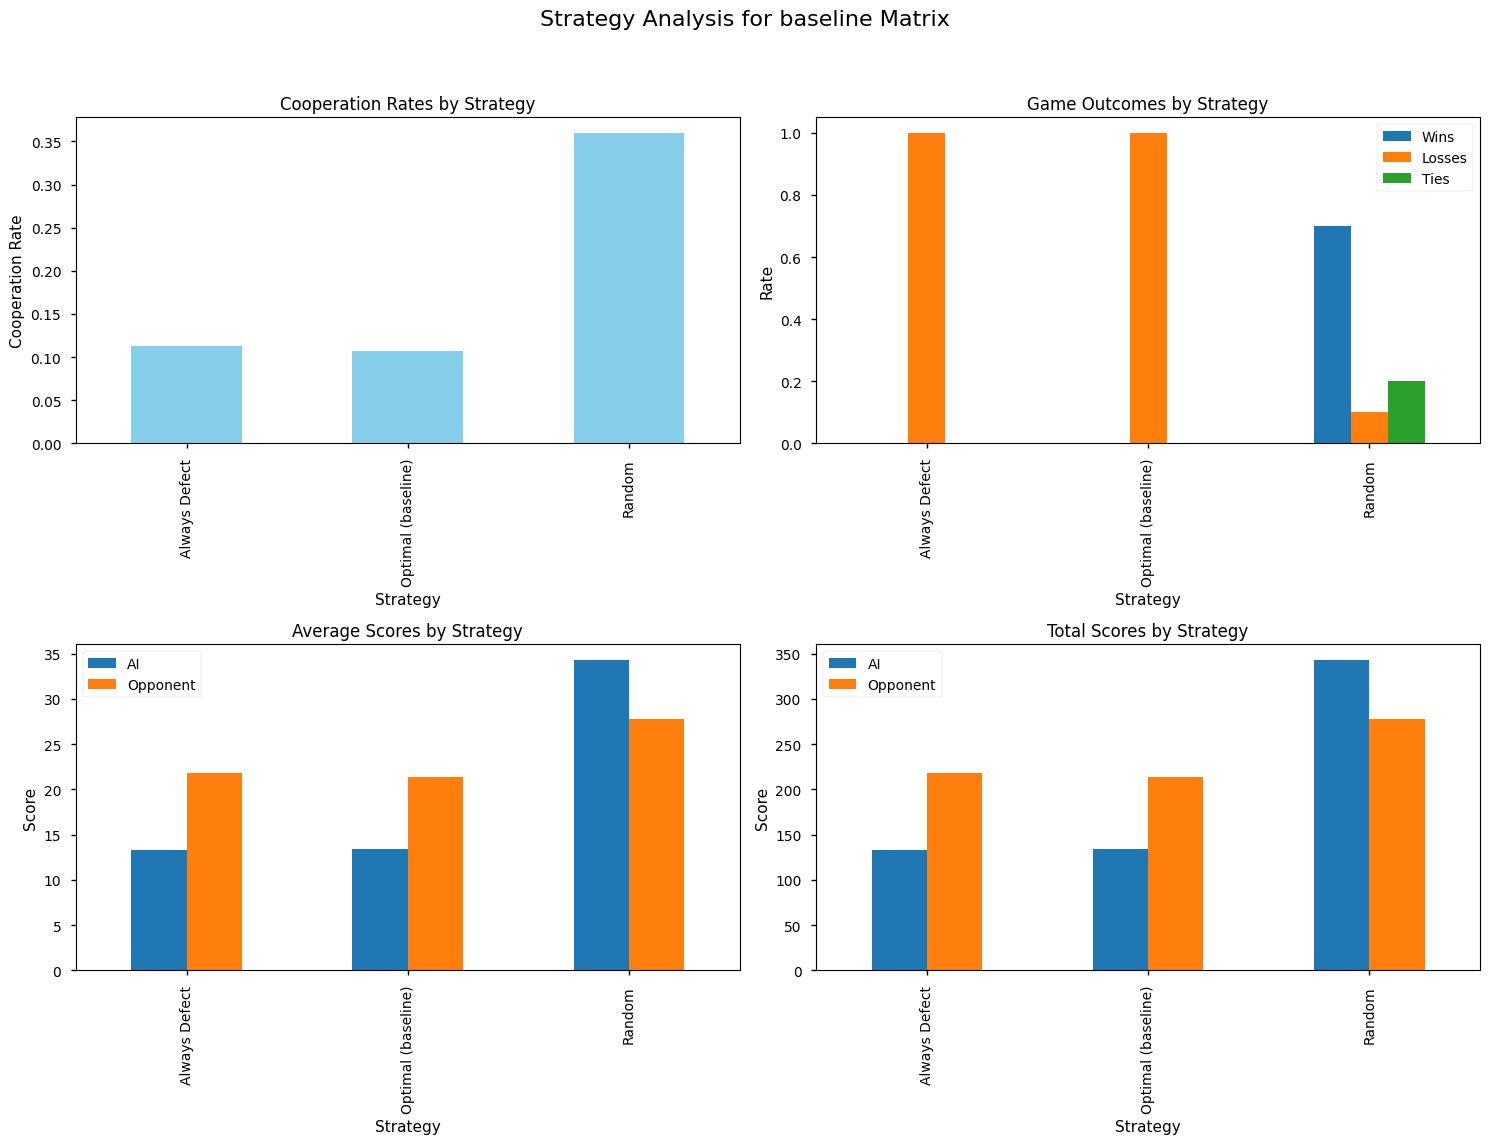

In [75]:
results = analyze_by_strategy('f5f136e5-98d2-4840-99f4-6ab10c3607ff')

In [ ]:
plt.style.available


Analysis for experiment fd71ebb7-cc81-4bd9-8d00-bac7a131c34b
Matrix Type: baseline
Player 1: claude_haiku
Player 2: multiple

Game Statistics:


,game_id,matrix_type,p1_coop_rate,p2_coop_rate,p1_final_score,p2_final_score,opponent_strategy,winner
0,05a50577-35ab-45f4-8465-a6e07793c365,baseline,0.3,0.0,7,22,Optimal (baseline),Opponent
1,100d42d4-8a27-4fa6-8a07-e2a57911afab,baseline,1.0,1.0,30,30,Tit for Tat,Opponent
2,10fa8119-98f9-4919-9a53-f72407a3f6a1,baseline,0.3,0.0,7,22,Optimal (baseline),Opponent
3,2520b0c0-f89e-4b7e-8dab-b677b0c29aa1,baseline,0.9,0.8,26,31,Random,Opponent
4,2eb4f7f2-987e-44e0-b1b8-c2000ed06001,baseline,0.3,0.0,7,22,Optimal (baseline),Opponent
5,324026e5-01c0-419d-a38a-4c99eae55837,baseline,1.0,1.0,30,30,"Since this is the first round of the game, the...",Opponent
6,3349981d-8210-4246-a883-4349c74416a9,baseline,1.0,1.0,30,30,"In the first round of the game, I will choose ...",Opponent
7,383d9f46-ce1c-4d1e-8ffd-0557a702809e,baseline,0.4,0.0,6,26,Always Defect,Opponent
8,3adcbb1c-a4ff-49c4-acd5-fad26603feb9,baseline,1.0,1.0,30,30,Tit for Tat,Opponent
9,45fbd8be-954e-4bb6-8d34-9a436ec655a1,baseline,0.3,0.0,7,22,Always Defect,Opponent



Analysis for experiment af70d67f-5ad9-4f21-9ece-2dba072b8e43
Matrix Type: mixed_30
Player 1: claude_haiku
Player 2: multiple

Game Statistics:


,game_id,matrix_type,p1_coop_rate,p2_coop_rate,p1_final_score,p2_final_score,opponent_strategy,winner
0,01137284-790d-4ab6-ab24-1e8a23129ffc,mixed_30,1.0,1.0,40,40,"For the first round, I'll choose to COOPERATE ...",Opponent
1,097ca3bf-4606-4661-aff5-306e1e245927,mixed_30,0.8,0.7,30,40,Random,Opponent
2,154718db-50ab-4b91-9f10-d8a0e3d9ed50,mixed_30,1.0,1.0,40,40,"This is the first round, so I have no prior hi...",Opponent
3,159ad197-f18c-4dae-82e9-3bcedaabc6bd,mixed_30,0.7,0.5,18,38,Random,Opponent
4,1d9fc6ed-17ff-4b3f-9bd3-7c728c2c3c92,mixed_30,0.1,0.0,-2,8,Always Defect,Opponent
5,32dea98f-da77-41f4-bad9-d40c16d03a9c,mixed_30,0.1,0.0,-2,8,Always Defect,Opponent
6,35129d09-528e-4517-a693-0f3b9b678ae5,mixed_30,0.4,0.7,44,14,Random,AI
7,3843d75f-ceff-41f4-9502-5e1d7ca1e632,mixed_30,1.0,1.0,40,40,"In the first round, I'll start with COOPERATE ...",Opponent
8,3c4b9a31-26d2-4dbc-9593-d07bde1d7928,mixed_30,0.3,0.5,32,12,Random,AI
9,41d055fa-06bd-42f6-b327-cde226b7a79f,mixed_30,0.1,0.0,-2,8,Always Defect,Opponent



Analysis for experiment 86b494d1-159e-477b-9757-05dbf37aa5de
Matrix Type: mixed_70
Player 1: claude_haiku
Player 2: multiple

Game Statistics:


,game_id,matrix_type,p1_coop_rate,p2_coop_rate,p1_final_score,p2_final_score,opponent_strategy,winner
0,078b6d51-0f45-427a-8f84-d8fc1322b7b0,mixed_70,1.0,1.0,30,30,"Since this is the first round, I will start wi...",Opponent
1,0819dbda-481d-4197-81bf-6b91bac12448,mixed_70,0.9,0.8,23,28,Random,Opponent
2,0faee054-b7c3-4210-b397-a2286e41d1e0,mixed_70,0.5,0.7,21,11,Random,AI
3,1762521c-818e-4570-9a5c-268b003c6947,mixed_70,0.8,0.7,18,23,Optimal (mixed_70),Opponent
4,212e011b-0879-46f4-b73b-8b5f6c285c84,mixed_70,1.0,1.0,30,30,"In the first round, I'll choose to COOPERATE f...",Opponent
5,21e5c98f-dd86-47c3-a7af-de2a7ceba428,mixed_70,0.9,0.8,23,28,Random,Opponent
6,242c32e9-4b12-46fc-a06a-c78d6e56e70c,mixed_70,0.2,0.4,6,-4,Random,AI
7,2757daf1-7211-4847-99af-9d82fca4ea60,mixed_70,0.8,0.6,12,22,Optimal (mixed_70),Opponent
8,2cf2ec97-9401-4d86-89d1-ed602b1cc2ac,mixed_70,1.0,1.0,30,30,"This is the first round, so I have no prior in...",Opponent
9,36fa4f13-f8f4-4ce1-9c1c-9b06f1c040fb,mixed_70,1.0,1.0,30,30,"Since this is the first round, I'll choose to ...",Opponent


FileNotFoundError: [Errno 2] No such file or directory: 'experiment_data/game_data/05a50577_games.csv'

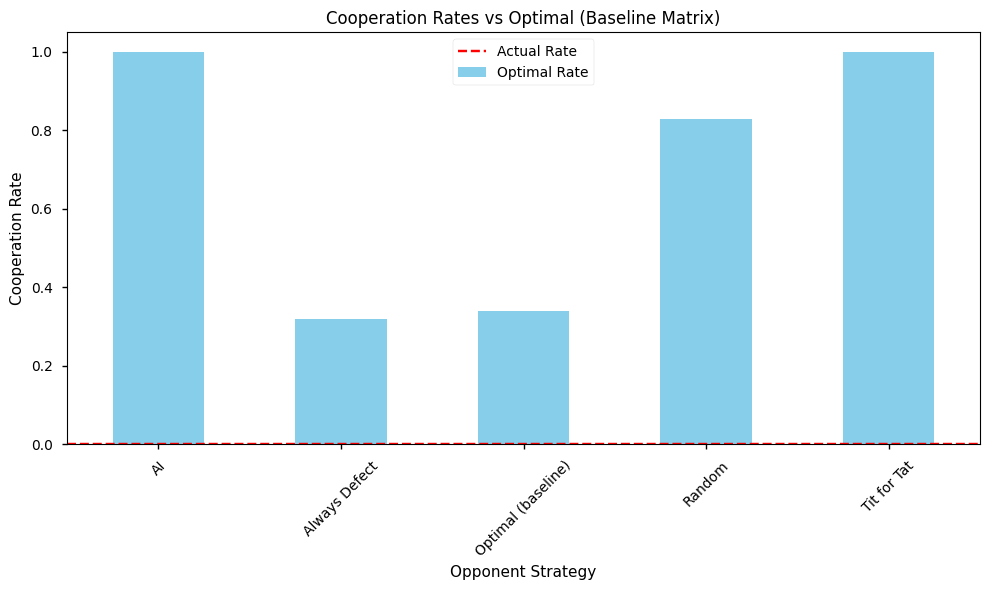

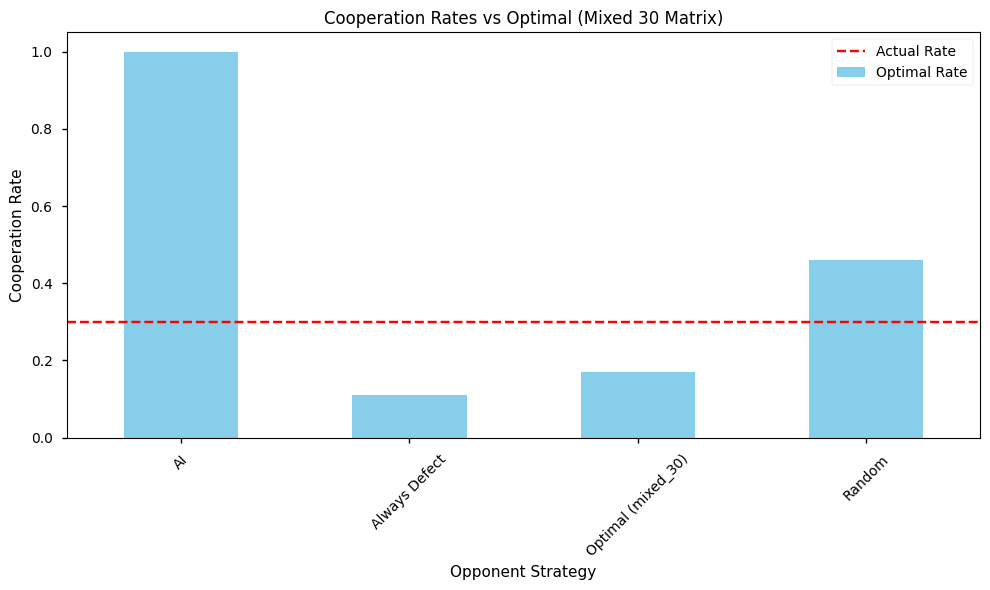

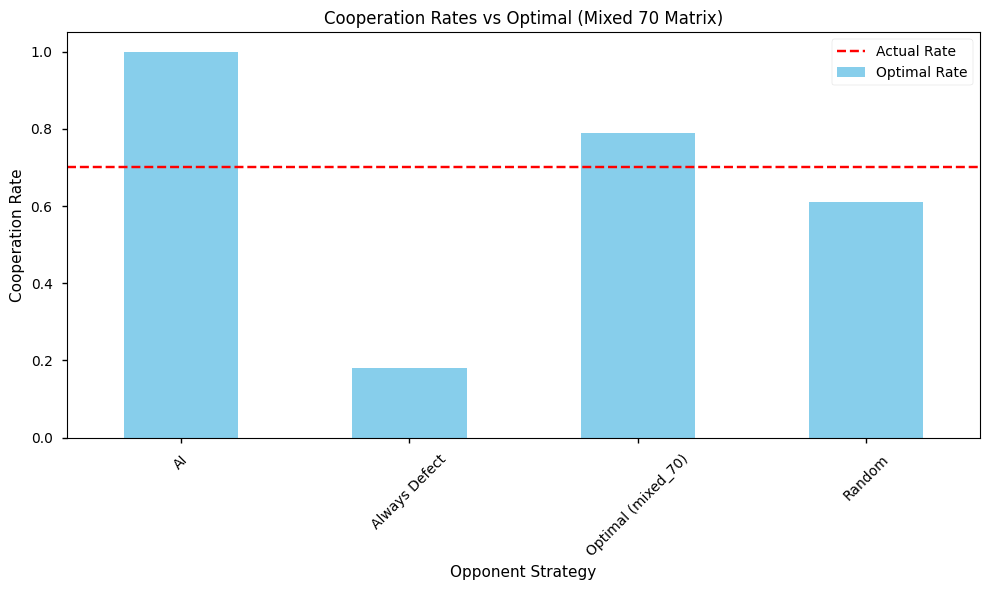

<Figure size 1200x600 with 0 Axes>

In [76]:
# Load all experiments
games_A = analyze_experiments('fd71ebb7-cc81-4bd9-8d00-bac7a131c34b')
games_B = analyze_experiments('af70d67f-5ad9-4f21-9ece-2dba072b8e43')  # Mixed 30
games_C = analyze_experiments('86b494d1-159e-477b-9757-05dbf37aa5de')  # Mixed 70

# Create all visualizations
matrices = ['Baseline', 'Mixed 30', 'Mixed 70']
optimal_rates = [0, .3, 0.7]

# Individual matrix analysis
for games, matrix, opt_rate in zip([games_A,games_B, games_C], matrices, optimal_rates):
    plot_cooperation_vs_optimal(games, opt_rate, matrix)

# Cross-matrix analysis
plot_first_moves([games_A,games_B, games_C], matrices)
plot_claude_v_claude([games_A,games_B, games_C], matrices)
plot_optimal_performance([games_A,games_B, games_C], matrices)